In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 12.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from scipy.stats import gaussian_kde, shapiro, wilcoxon

In [ ]:
import pandas as pd

# Load
re1 = pd.read_csv('backtest_results.csv')
re2 = pd.read_csv('backtest_results_with_tft_walkforward.csv')

# Consistent strategy label (fix typo if exists)
re1['estrategia'] = 'trading'
re2['estrategia'] = 'trading_DL'
benchmark_return = re1['benchmark_return']
trading_returns = re1['total_return']
trading_dl_returns = re2['total_return']

# Genera un dataframe con variable total_return con benchmark_return, trading_returns y trading_dl_returns y otra variable 'estrategia' con valor benchmark, trading y trading_DL
# Asegura Series 1D y alínealas si hace falta (opcional: dropna para evitar NaNs)
benchmark_s = pd.Series(benchmark_return).dropna()
trading_s   = pd.Series(trading_returns).dropna()
tradingdl_s = pd.Series(trading_dl_returns).dropna()

returns = pd.concat([
    pd.DataFrame({'total_return': benchmark_s.values, 'estrategia': 'benchmark'}),
    pd.DataFrame({'total_return': trading_s.values,   'estrategia': 'trading'}),
    pd.DataFrame({'total_return': tradingdl_s.values, 'estrategia': 'trading_DL'}),
], ignore_index=True)


if 'estragia' in re1.columns: re1 = re1.drop(columns=['estragia'])
if 'estragia' in re2.columns: re2 = re2.drop(columns=['estragia'])

# Drop hyperparam columns if they exist
cols_to_drop = [
    'rsi_window', 'bb_window', 'bb_alpha',
    'ema_fast_span', 'ema_slow_span',
    'sl_stop', 'tp_stop', 'benchmark_return','total_return'
]
re1 = re1.drop(columns=[c for c in cols_to_drop if c in re1.columns], errors='ignore')
re2 = re2.drop(columns=[c for c in cols_to_drop if c in re2.columns], errors='ignore')

# Make sure estrategia is included in the final set of columns
common_cols = sorted(set(re1.columns) & set(re2.columns))
if 'estrategia' not in common_cols:
    common_cols.append('estrategia')

# nxm each
re_1 = re1[common_cols].copy()
re_2 = re2[common_cols].copy()

# 2n × m (stack both)
re = pd.concat([re_1, re_2], ignore_index=True)

In [ ]:
import plotly.express as px

fig = px.violin(
    returns,
    x='estrategia',
    y='total_return',
    color='estrategia',
    box=True,
    points='all',
    hover_data=['estrategia']
)

fig.update_layout(
    title='Comparativa de total_return por estrategia',
    yaxis_title='total_return',
    xaxis_title='Estrategia',
    legend_title='Estrategia',
    width=900,
    height=500
)

fig.show()

In [ ]:
returns.head()
summary = returns.groupby('estrategia')['total_return'].agg(['min', 'mean', 'median', 'std', 'max'])
print(summary)

                  min        mean      median         std          max
estrategia                                                            
benchmark  -67.422748  176.203949   81.977671  336.198179  2191.500000
trading    -51.965007  163.382693  113.041212  176.031798  1002.026788
trading_DL -42.776103  171.739125  111.548637  227.108249  1715.555593


In [ ]:
metrics = ['sharpe_ratio', 'total_trades', 'win_rate']

In [ ]:
import pandas as pd

stat_order  = ['min', 'mean', '50%', 'std', 'max', '25%', '75%']
stat_rename = {'min':'Min', 'mean':'Mean', '50%':'Median', 'std':'Std', 'max':'Max', '25%':'Q1', '75%':'Q3'}

desc = (
    re
    .groupby('estrategia')[metrics]
    .describe(percentiles=[0.25, 0.5, 0.75])
)

# Reordenar y renombrar SOLO el nivel de estadístico (2º nivel)
desc = desc.loc[:, pd.IndexSlice[:, stat_order]]
desc = desc.rename(columns=stat_rename, level=1)

pretty = desc.round(4)   # <- tabla final
tidy = (
    desc   # ya reordenado y con nombres bonitos en la Opción A
    .stack(level=0)                         # pasa la métrica a filas
    .rename_axis(index=['model', 'Metric']) # renombra índices
    .reset_index()                          # a DataFrame
    .round(4)
)

print(tidy)

# (Opcional) Exportar
# tidy.to_csv('model_metric_summary.csv', index=False)
# Ejemplo de columnas: Accuracy_Mean, RMSE_Q1, ...

        model        Metric      Min     Mean   Median      Std       Max  \
0     trading  sharpe_ratio  -0.1726   0.8219   0.8374   0.3716    1.6621   
1     trading  total_trades  22.0000  92.3168  93.0000  32.2735  177.0000   
2     trading      win_rate  34.4538  46.8686  46.7391   5.3882   65.3846   
3  trading_DL  sharpe_ratio  -0.1415   0.8222   0.8374   0.3747    1.9000   
4  trading_DL  total_trades  22.0000  96.1881  98.0000  33.1553  184.0000   
5  trading_DL      win_rate  35.5372  47.5413  47.0588   5.5096   65.3846   

        Q1        Q3  
0   0.5913    1.0665  
1  65.0000  112.0000  
2  43.3333   49.5413  
3   0.5674    1.0574  
4  68.0000  117.0000  
5  44.4444   50.3497  


/tmp/ipython-input-2982884552.py:19: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [ ]:
import plotly.express as px
import pandas as pd

for metric in metrics:
    df_long = pd.melt(re,
                      id_vars=['ticker', 'estrategia'],
                      value_vars=[metric],
                      var_name='Metric',
                      value_name='Value')

    fig = px.violin(df_long,
                    x='estrategia',
                    y='Value',
                    color='estrategia',
                    box=True,
                    points='all',
                    hover_data=['ticker', 'estrategia'])

    fig.update_layout(title=f'Comparativa de {metric} por estrategia',
                      yaxis_title=metric,
                      xaxis_title='Estrategia',
                      legend_title='Estrategia',
                      width=900,
                      height=500)

    fig.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg

# Tu DataFrame re ya debe estar cargado
# Verificar que existe el DataFrame
if 're' not in locals():
    print("⚠️  Asegúrate de que tu DataFrame 're' esté cargado")
    print("El DataFrame debe tener columnas: 'estrategia', 'SHARPE_RATIO', 'TOTAL_TRADES', 'WIN_RATE'")
else:
    print(f"✅ DataFrame encontrado con {len(re)} filas y {len(re.columns)} columnas")
    print(f"estrategia únicos: {list(re['estrategia'].unique())}")

# Definir las métricas (ajusta según tu DataFrame)
metrics = ['sharpe_ratio', 'total_trades', 'win_rate']

# =========================
# 1) Mean + 95% CI per estrategia
# =========================
def mean_ci(series, alpha=0.95):
    s = pd.Series(series).dropna()
    n = len(s)
    mean = s.mean()
    if n < 2:
        return pd.Series({'mean': mean, 'ci_lower': np.nan, 'ci_upper': np.nan, 'n': n})
    sem = stats.sem(s)
    lo, hi = stats.t.interval(alpha, df=n-1, loc=mean, scale=sem)
    return pd.Series({'mean': mean, 'ci_lower': lo, 'ci_upper': hi, 'n': n})

# Calcular estadísticas por estrategia
summary_stats = (
    re.groupby('estrategia')[metrics]
    .apply(lambda g: g.apply(mean_ci))
)

print("=" * 80)
print("RESUMEN ESTADÍSTICO POR estrategia")
print("=" * 80)

# Reorganizar los datos para una mejor presentación
for metric in metrics:
    print(f"\n📊 {metric.upper()}")
    print("-" * 60)

    # Crear tabla organizada
    metric_table = []
    for estrategia in summary_stats.index.get_level_values(0).unique():
        try:
            stats_data = summary_stats.loc[estrategia, metric]
            metric_table.append({
                'estrategia': estrategia,
                'Media': stats_data['mean'],
                'IC_Inferior': stats_data['ci_lower'],
                'IC_Superior': stats_data['ci_upper'],
                'N': int(stats_data['n'])
            })
        except (KeyError, IndexError):
            continue

    if metric_table:
        df_metric = pd.DataFrame(metric_table)
        # Formatear las columnas numéricas
        for col in ['Media', 'IC_Inferior', 'IC_Superior']:
            df_metric[col] = df_metric[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        print(df_metric.to_string(index=False))

# =========================
# 2) Comparaciones por pares mejoradas
# =========================
def calculate_mean_difference_ci(group1, group2, alpha=0.95):
    """Calcula la diferencia de medias y su IC"""
    diff = group2.mean() - group1.mean()

    # Pooled standard error
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(ddof=1), group2.std(ddof=1)

    # Welch's t-test approach for unequal variances
    se_diff = np.sqrt((s1**2/n1) + (s2**2/n2))

    # Degrees of freedom (Welch-Satterthwaite)
    df = ((s1**2/n1 + s2**2/n2)**2) / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))

    # Confidence interval
    t_crit = stats.t.ppf((1 + alpha)/2, df)
    ci_lower = diff - t_crit * se_diff
    ci_upper = diff + t_crit * se_diff

    return diff, ci_lower, ci_upper

def perform_manual_ttest(group1, group2):
    """Realiza t-test manual usando scipy.stats"""
    try:
        # Welch's t-test (no asume varianzas iguales)
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return p_val
    except:
        return np.nan

print("\n" + "=" * 80)
print("COMPARACIONES POR PARES estrategia_2 - estrategia_1")
print("=" * 80)

unique_estrategias = re['estrategia'].dropna().unique()
if len(unique_estrategias) < 2:
    print("\n❌ No hay suficientes grupos para comparar (se necesitan ≥ 2).")
else:
    for metric in metrics:
        print(f"\n🔍 {metric.upper()}")
        print("-" * 70)

        comparison_table = []

        # Realizar comparaciones por pares manualmente
        for i in range(len(unique_estrategias)):
            for j in range(i+1, len(unique_estrategias)):
                estrategia1 = unique_estrategias[i]
                estrategia2 = unique_estrategias[j]

                # Obtener los datos de cada grupo
                group1 = re[re['estrategia'] == estrategia1][metric].dropna()
                group2 = re[re['estrategia'] == estrategia2][metric].dropna()

                if len(group1) > 0 and len(group2) > 0:
                    # Calcular diferencia de medias y CI
                    diff, ci_lower, ci_upper = calculate_mean_difference_ci(group1, group2)

                    # Realizar t-test
                    p_val = perform_manual_ttest(group1, group2)

                    # Aplicar corrección de Bonferroni (si hay múltiples comparaciones)
                    n_comparisons = len(unique_estrategias) * (len(unique_estrategias) - 1) / 2
                    p_corr = min(p_val * n_comparisons, 1.0) if pd.notna(p_val) else np.nan

                    # Determinar significancia
                    if pd.notna(p_corr):
                        sig_level = "***" if p_corr < 0.001 else "**" if p_corr < 0.01 else "*" if p_corr < 0.05 else "ns"
                    else:
                        sig_level = "ns"

                    comparison_table.append({
                        'estrategia_1': estrategia1,
                        'estrategia_2': estrategia2,
                        'Dif_Medias': diff,
                        'IC_Inf_Dif': ci_lower,
                        'IC_Sup_Dif': ci_upper,
                        'p_valor': p_val,
                        'p_corregido': p_corr,
                        'Significancia': sig_level
                    })

        if comparison_table:
            df_comparisons = pd.DataFrame(comparison_table)

            # Formatear las columnas numéricas
            numeric_cols = ['Dif_Medias', 'IC_Inf_Dif', 'IC_Sup_Dif', 'p_valor', 'p_corregido']
            for col in numeric_cols:
                df_comparisons[col] = df_comparisons[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

            # Mostrar tabla
            display_cols = ['estrategia_1', 'estrategia_2', 'Dif_Medias', 'IC_Inf_Dif', 'IC_Sup_Dif', 'p_corregido', 'Significancia']
            print(df_comparisons[display_cols].to_string(index=False))

            # Agregar interpretación
            significant_comparisons = []
            for i, row in enumerate(comparison_table):
                if row['Significancia'] != 'ns':
                    significant_comparisons.append(row)

            if significant_comparisons:
                print(f"\n✅ Diferencias significativas encontradas: {len(significant_comparisons)}")
                for comp in significant_comparisons:
                    p_val = comp['p_corregido']
                    p_formatted = f"{p_val:.4f}" if pd.notna(p_val) else "N/A"
                    print(f"   • {comp['estrategia_1']} vs {comp['estrategia_2']}: p = {p_formatted} {comp['Significancia']}")
            else:
                print(f"\n❌ No se encontraron diferencias significativas (p < 0.05)")

# =========================
# 3) Resumen ejecutivo
# =========================
print("\n" + "=" * 80)
print("RESUMEN EJECUTIVO")
print("=" * 80)

print("\n📈 RENDIMIENTO GENERAL POR estrategia:")
print("-" * 40)

# Calcular ranking por métrica
for metric in metrics:
    print(f"\n{metric}:")
    metric_means = []
    for estrategia in unique_estrategias:
        estrategia_data = re[re['estrategia'] == estrategia][metric].dropna()
        if len(estrategia_data) > 0:
            metric_means.append((estrategia, estrategia_data.mean()))

    # Para métricas como SHARPE_RATIO y WIN_RATE, mayor es mejor
    # Para RMSE, menor es mejor (pero no parece estar en tus datos)
    metric_means.sort(key=lambda x: x[1], reverse=True)

    for i, (estrategia, mean_val) in enumerate(metric_means, 1):
        print(f"  {i}. {estrategia}: {mean_val:.4f}")

print("\n" + "=" * 80)
print("Leyenda: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo")
print("IC = Intervalo de Confianza al 95%")
print("Dif_Medias = estrategia_2 - estrategia_1")
print("p_corregido = p-valor con corrección de Bonferroni")
print("=" * 80)

✅ DataFrame encontrado con 202 filas y 5 columnas
estrategia únicos: ['trading', 'trading_DL']
RESUMEN ESTADÍSTICO POR estrategia

📊 SHARPE_RATIO
------------------------------------------------------------
estrategia  Media IC_Inferior IC_Superior   N
   trading 0.8219      0.7486      0.8953 101
trading_DL 0.8222      0.7483      0.8962 101

📊 TOTAL_TRADES
------------------------------------------------------------
estrategia   Media IC_Inferior IC_Superior   N
   trading 92.3168     85.9456     98.6880 101
trading_DL 96.1881     89.6428    102.7334 101

📊 WIN_RATE
------------------------------------------------------------
estrategia   Media IC_Inferior IC_Superior   N
   trading 46.8686     45.8049     47.9323 101
trading_DL 47.5413     46.4536     48.6290 101

COMPARACIONES POR PARES estrategia_2 - estrategia_1

🔍 SHARPE_RATIO
----------------------------------------------------------------------
estrategia_1 estrategia_2 Dif_Medias IC_Inf_Dif IC_Sup_Dif p_corregido Significanci

In [ ]:
# Lista para almacenar resultados
posthoc_results = []

metric = 'total_return'
print(f"\n🔍 Test post-hoc para: {metric}")

# Obtenemos las estrategias únicos
estrategias = returns['estrategia'].unique()

# Todas las combinaciones de estrategias (pares)
for estrategia1, estrategia2 in combinations(estrategias, 2):
    data1 = returns[returns['estrategia'] == estrategia1][metric].dropna()
    data2 = returns[returns['estrategia'] == estrategia2][metric].dropna()

    # Mann–Whitney U test
    stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')

    # Calcular estadísticas descriptivas
    mean1, ci1_low, ci1_high = mean_ci(data1)
    mean2, ci2_low, ci2_high = mean_ci(data2)

    print(f"Comparando {estrategia1} vs {estrategia2} → p-value = {p_value:.4f}")
    print(f"   {estrategia1}: mean={mean1:.3f}, 95%CI=({ci1_low:.3f}, {ci1_high:.3f})")
    print(f"   {estrategia2}: mean={mean2:.3f}, 95%CI=({ci2_low:.3f}, {ci2_high:.3f})")

    posthoc_results.append({
        'Metric': metric,
        'estrategia_1': estrategia1,
        'Mean_1': mean1,
        'CI95_low_1': ci1_low,
        'CI95_high_1': ci1_high,
        'estrategia_2': estrategia2,
        'Mean_2': mean2,
        'CI95_low_2': ci2_low,
        'CI95_high_2': ci2_high,
        'p_value': p_value,
        'Significant (alpha=0.05)': p_value < 0.05
    })

# Convertimos a DataFrame
posthoc_df = pd.DataFrame(posthoc_results)

print("\n✅ Resumen post-hoc con medias e IC95%:")
print(posthoc_df)


🔍 Test post-hoc para: total_return
Comparando benchmark vs trading → p-value = 0.0835
   benchmark: mean=176.204, 95%CI=(109.834, 242.574)
   trading: mean=163.383, 95%CI=(128.632, 198.134)
Comparando benchmark vs trading_DL → p-value = 0.1006
   benchmark: mean=176.204, 95%CI=(109.834, 242.574)
   trading_DL: mean=171.739, 95%CI=(126.905, 216.573)
Comparando trading vs trading_DL → p-value = 0.9147
   trading: mean=163.383, 95%CI=(128.632, 198.134)
   trading_DL: mean=171.739, 95%CI=(126.905, 216.573)

✅ Resumen post-hoc con medias e IC95%:
         Metric estrategia_1      Mean_1  CI95_low_1  CI95_high_1  \
0  total_return    benchmark  176.203949  109.834211   242.573687   
1  total_return    benchmark  176.203949  109.834211   242.573687   
2  total_return      trading  163.382693  128.631808   198.133578   

  estrategia_2      Mean_2  CI95_low_2  CI95_high_2   p_value  \
0      trading  163.382693  128.631808   198.133578  0.083485   
1   trading_DL  171.739125  126.905108   216

In [ ]:
# Tu DataFrame re ya debe estar cargado
# Verificar que existe el DataFrame
if 'returns' not in locals():
    print("⚠️  Asegúrate de que tu DataFrame 'returns' esté cargado")
    print("El DataFrame debe tener columnas: 'estrategia', 'total_return'")
else:
    print(f"✅ DataFrame encontrado con {len(returns)} filas y {len(returns.columns)} columnas")
    print(f"estrategia únicos: {list(returns['estrategia'].unique())}")

# Definir las métricas (ajusta según tu DataFrame)
metrics = ['total_return']

# =========================
# 1) Mean + 95% CI per estrategia
# =========================
def mean_ci(series, alpha=0.95):
    s = pd.Series(series).dropna()
    n = len(s)
    mean = s.mean()
    if n < 2:
        return pd.Series({'mean': mean, 'ci_lower': np.nan, 'ci_upper': np.nan, 'n': n})
    sem = stats.sem(s)
    lo, hi = stats.t.interval(alpha, df=n-1, loc=mean, scale=sem)
    return pd.Series({'mean': mean, 'ci_lower': lo, 'ci_upper': hi, 'n': n})

# Calcular estadísticas por estrategia
summary_stats = (
    returns.groupby('estrategia')[metrics]
    .apply(lambda g: g.apply(mean_ci))
)

print("=" * 80)
print("RESUMEN ESTADÍSTICO POR estrategia")
print("=" * 80)

# Reorganizar los datos para una mejor presentación
for metric in metrics:
    print(f"\n📊 {metric.upper()}")
    print("-" * 60)

    # Crear tabla organizada
    metric_table = []
    for estrategia in summary_stats.index.get_level_values(0).unique():
        try:
            stats_data = summary_stats.loc[estrategia, metric]
            metric_table.append({
                'estrategia': estrategia,
                'Media': stats_data['mean'],
                'IC_Inferior': stats_data['ci_lower'],
                'IC_Superior': stats_data['ci_upper'],
                'N': int(stats_data['n'])
            })
        except (KeyError, IndexError):
            continue

    if metric_table:
        df_metric = pd.DataFrame(metric_table)
        # Formatear las columnas numéricas
        for col in ['Media', 'IC_Inferior', 'IC_Superior']:
            df_metric[col] = df_metric[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        print(df_metric.to_string(index=False))

# =========================
# 2) Comparaciones por pares mejoradas
# =========================
def calculate_mean_difference_ci(group1, group2, alpha=0.95):
    """Calcula la diferencia de medias y su IC"""
    diff = group2.mean() - group1.mean()

    # Pooled standard error
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(ddof=1), group2.std(ddof=1)

    # Welch's t-test approach for unequal variances
    se_diff = np.sqrt((s1**2/n1) + (s2**2/n2))

    # Degrees of freedom (Welch-Satterthwaite)
    df = ((s1**2/n1 + s2**2/n2)**2) / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))

    # Confidence interval
    t_crit = stats.t.ppf((1 + alpha)/2, df)
    ci_lower = diff - t_crit * se_diff
    ci_upper = diff + t_crit * se_diff

    return diff, ci_lower, ci_upper

def perform_manual_ttest(group1, group2):
    """Realiza t-test manual usando scipy.stats"""
    try:
        # Welch's t-test (no asume varianzas iguales)
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return p_val
    except:
        return np.nan

print("\n" + "=" * 80)
print("COMPARACIONES POR PARES estrategia_2 - estrategia_1")
print("=" * 80)

unique_estrategias = returns['estrategia'].dropna().unique()
if len(unique_estrategias) < 2:
    print("\n❌ No hay suficientes grupos para comparar (se necesitan ≥ 2).")
else:
    for metric in metrics:
        print(f"\n🔍 {metric.upper()}")
        print("-" * 70)

        comparison_table = []

        # Realizar comparaciones por pares manualmente
        for i in range(len(unique_estrategias)):
            for j in range(i+1, len(unique_estrategias)):
                estrategia1 = unique_estrategias[i]
                estrategia2 = unique_estrategias[j]

                # Obtener los datos de cada grupo
                group1 = returns[returns['estrategia'] == estrategia1][metric].dropna()
                group2 = returns[returns['estrategia'] == estrategia2][metric].dropna()

                if len(group1) > 0 and len(group2) > 0:
                    # Calcular diferencia de medias y CI
                    diff, ci_lower, ci_upper = calculate_mean_difference_ci(group1, group2)

                    # Realizar t-test
                    p_val = perform_manual_ttest(group1, group2)

                    # Aplicar corrección de Bonferroni (si hay múltiples comparaciones)
                    n_comparisons = len(unique_estrategias) * (len(unique_estrategias) - 1) / 2
                    p_corr = min(p_val * n_comparisons, 1.0) if pd.notna(p_val) else np.nan

                    # Determinar significancia
                    if pd.notna(p_corr):
                        sig_level = "***" if p_corr < 0.001 else "**" if p_corr < 0.01 else "*" if p_corr < 0.05 else "ns"
                    else:
                        sig_level = "ns"

                    comparison_table.append({
                        'estrategia_1': estrategia1,
                        'estrategia_2': estrategia2,
                        'Dif_Medias': diff,
                        'IC_Inf_Dif': ci_lower,
                        'IC_Sup_Dif': ci_upper,
                        'p_valor': p_val,
                        'p_corregido': p_corr,
                        'Significancia': sig_level
                    })

        if comparison_table:
            df_comparisons = pd.DataFrame(comparison_table)

            # Formatear las columnas numéricas
            numeric_cols = ['Dif_Medias', 'IC_Inf_Dif', 'IC_Sup_Dif', 'p_valor', 'p_corregido']
            for col in numeric_cols:
                df_comparisons[col] = df_comparisons[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

            # Mostrar tabla
            display_cols = ['estrategia_1', 'estrategia_2', 'Dif_Medias', 'IC_Inf_Dif', 'IC_Sup_Dif', 'p_corregido', 'Significancia']
            print(df_comparisons[display_cols].to_string(index=False))

            # Agregar interpretación
            significant_comparisons = []
            for i, row in enumerate(comparison_table):
                if row['Significancia'] != 'ns':
                    significant_comparisons.append(row)

            if significant_comparisons:
                print(f"\n✅ Diferencias significativas encontradas: {len(significant_comparisons)}")
                for comp in significant_comparisons:
                    p_val = comp['p_corregido']
                    p_formatted = f"{p_val:.4f}" if pd.notna(p_val) else "N/A"
                    print(f"   • {comp['estrategia_1']} vs {comp['estrategia_2']}: p = {p_formatted} {comp['Significancia']}")
            else:
                print(f"\n❌ No se encontraron diferencias significativas (p < 0.05)")

# =========================
# 3) Resumen ejecutivo
# =========================
print("\n" + "=" * 80)
print("RESUMEN EJECUTIVO")
print("=" * 80)

print("\n📈 RENDIMIENTO GENERAL POR estrategia:")
print("-" * 40)

# Calcular ranking por métrica
for metric in metrics:
    print(f"\n{metric}:")
    metric_means = []
    for estrategia in unique_estrategias:
        estrategia_data = returns[returns['estrategia'] == estrategia][metric].dropna()
        if len(estrategia_data) > 0:
            metric_means.append((estrategia, estrategia_data.mean()))

    # Para métricas como SHARPE_RATIO y WIN_RATE, mayor es mejor
    # Para RMSE, menor es mejor (pero no parece estar en tus datos)
    metric_means.sort(key=lambda x: x[1], reverse=True)

    for i, (estrategia, mean_val) in enumerate(metric_means, 1):
        print(f"  {i}. {estrategia}: {mean_val:.4f}")

print("\n" + "=" * 80)
print("Leyenda: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo")
print("IC = Intervalo de Confianza al 95%")
print("Dif_Medias = estrategia_2 - estrategia_1")
print("p_corregido = p-valor con corrección de Bonferroni")
print("=" * 80)

✅ DataFrame encontrado con 303 filas y 2 columnas
estrategia únicos: ['benchmark', 'trading', 'trading_DL']
RESUMEN ESTADÍSTICO POR estrategia

📊 TOTAL_RETURN
------------------------------------------------------------
estrategia    Media IC_Inferior IC_Superior   N
 benchmark 176.2039    109.8342    242.5737 101
   trading 163.3827    128.6318    198.1336 101
trading_DL 171.7391    126.9051    216.5731 101

COMPARACIONES POR PARES estrategia_2 - estrategia_1

🔍 TOTAL_RETURN
----------------------------------------------------------------------
estrategia_1 estrategia_2 Dif_Medias IC_Inf_Dif IC_Sup_Dif p_corregido Significancia
   benchmark      trading   -12.8213   -87.4297    61.7872      1.0000            ns
   benchmark   trading_DL    -4.4648   -84.1388    75.2092      1.0000            ns
     trading   trading_DL     8.3564   -48.0446    64.7574      1.0000            ns

❌ No se encontraron diferencias significativas (p < 0.05)

RESUMEN EJECUTIVO

📈 RENDIMIENTO GENERAL POR est

In [ ]:
# Tu DataFrame re ya debe estar cargado
# Verificar que existe el DataFrame
if 're' not in locals():
    print("⚠️  Asegúrate de que tu DataFrame 're' esté cargado")
    print("El DataFrame debe tener columnas: 'estrategia', 'SHARPE_RATIO', 'TOTAL_TRADES', 'WIN_RATE'")
else:
    print(f"✅ DataFrame encontrado con {len(re)} filas y {len(re.columns)} columnas")
    print(f"estrategia únicos: {list(re['estrategia'].unique())}")

# Definir las métricas (ajusta según tu DataFrame)
metrics = ['sharpe_ratio', 'total_trades', 'win_rate']

# =========================
# 1) Mean + 95% CI per estrategia
# =========================
def mean_ci(series, alpha=0.95):
    s = pd.Series(series).dropna()
    n = len(s)
    mean = s.mean()
    if n < 2:
        return pd.Series({'mean': mean, 'ci_lower': np.nan, 'ci_upper': np.nan, 'n': n})
    sem = stats.sem(s)
    lo, hi = stats.t.interval(alpha, df=n-1, loc=mean, scale=sem)
    return pd.Series({'mean': mean, 'ci_lower': lo, 'ci_upper': hi, 'n': n})

# Calcular estadísticas por estrategia
summary_stats = (
    re.groupby('estrategia')[metrics]
    .apply(lambda g: g.apply(mean_ci))
)

print("=" * 80)
print("RESUMEN ESTADÍSTICO POR estrategia")
print("=" * 80)

# Reorganizar los datos para una mejor presentación
for metric in metrics:
    print(f"\n📊 {metric.upper()}")
    print("-" * 60)

    # Crear tabla organizada
    metric_table = []
    for estrategia in summary_stats.index.get_level_values(0).unique():
        try:
            stats_data = summary_stats.loc[estrategia, metric]
            metric_table.append({
                'estrategia': estrategia,
                'Media': stats_data['mean'],
                'IC_Inferior': stats_data['ci_lower'],
                'IC_Superior': stats_data['ci_upper'],
                'N': int(stats_data['n'])
            })
        except (KeyError, IndexError):
            continue

    if metric_table:
        df_metric = pd.DataFrame(metric_table)
        # Formatear las columnas numéricas
        for col in ['Media', 'IC_Inferior', 'IC_Superior']:
            df_metric[col] = df_metric[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        print(df_metric.to_string(index=False))

# =========================
# 2) Comparaciones por pares mejoradas
# =========================
def calculate_mean_difference_ci(group1, group2, alpha=0.95):
    """Calcula la diferencia de medias y su IC"""
    diff = group2.mean() - group1.mean()

    # Pooled standard error
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(ddof=1), group2.std(ddof=1)

    # Welch's t-test approach for unequal variances
    se_diff = np.sqrt((s1**2/n1) + (s2**2/n2))

    # Degrees of freedom (Welch-Satterthwaite)
    df = ((s1**2/n1 + s2**2/n2)**2) / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))

    # Confidence interval
    t_crit = stats.t.ppf((1 + alpha)/2, df)
    ci_lower = diff - t_crit * se_diff
    ci_upper = diff + t_crit * se_diff

    return diff, ci_lower, ci_upper

def perform_manual_ttest(group1, group2):
    """Realiza t-test manual usando scipy.stats"""
    try:
        # Welch's t-test (no asume varianzas iguales)
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return p_val
    except:
        return np.nan

print("\n" + "=" * 80)
print("COMPARACIONES POR PARES estrategia_2 - estrategia_1")
print("=" * 80)

unique_estrategias = re['estrategia'].dropna().unique()
if len(unique_estrategias) < 2:
    print("\n❌ No hay suficientes grupos para comparar (se necesitan ≥ 2).")
else:
    for metric in metrics:
        print(f"\n🔍 {metric.upper()}")
        print("-" * 70)

        comparison_table = []

        # Realizar comparaciones por pares manualmente
        for i in range(len(unique_estrategias)):
            for j in range(i+1, len(unique_estrategias)):
                estrategia1 = unique_estrategias[i]
                estrategia2 = unique_estrategias[j]

                # Obtener los datos de cada grupo
                group1 = re[re['estrategia'] == estrategia1][metric].dropna()
                group2 = re[re['estrategia'] == estrategia2][metric].dropna()

                if len(group1) > 0 and len(group2) > 0:
                    # Calcular diferencia de medias y CI
                    diff, ci_lower, ci_upper = calculate_mean_difference_ci(group1, group2)

                    # Realizar t-test
                    p_val = perform_manual_ttest(group1, group2)

                    # Aplicar corrección de Bonferroni (si hay múltiples comparaciones)
                    n_comparisons = len(unique_estrategias) * (len(unique_estrategias) - 1) / 2
                    p_corr = min(p_val * n_comparisons, 1.0) if pd.notna(p_val) else np.nan

                    # Determinar significancia
                    if pd.notna(p_corr):
                        sig_level = "***" if p_corr < 0.001 else "**" if p_corr < 0.01 else "*" if p_corr < 0.05 else "ns"
                    else:
                        sig_level = "ns"

                    comparison_table.append({
                        'estrategia_1': estrategia1,
                        'estrategia_2': estrategia2,
                        'Dif_Medias': diff,
                        'IC_Inf_Dif': ci_lower,
                        'IC_Sup_Dif': ci_upper,
                        'p_valor': p_val,
                        'p_corregido': p_corr,
                        'Significancia': sig_level
                    })

        if comparison_table:
            df_comparisons = pd.DataFrame(comparison_table)

            # Formatear las columnas numéricas
            numeric_cols = ['Dif_Medias', 'IC_Inf_Dif', 'IC_Sup_Dif', 'p_valor', 'p_corregido']
            for col in numeric_cols:
                df_comparisons[col] = df_comparisons[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

            # Mostrar tabla
            display_cols = ['estrategia_1', 'estrategia_2', 'Dif_Medias', 'IC_Inf_Dif', 'IC_Sup_Dif', 'p_corregido', 'Significancia']
            print(df_comparisons[display_cols].to_string(index=False))

            # Agregar interpretación
            significant_comparisons = []
            for i, row in enumerate(comparison_table):
                if row['Significancia'] != 'ns':
                    significant_comparisons.append(row)

            if significant_comparisons:
                print(f"\n✅ Diferencias significativas encontradas: {len(significant_comparisons)}")
                for comp in significant_comparisons:
                    p_val = comp['p_corregido']
                    p_formatted = f"{p_val:.4f}" if pd.notna(p_val) else "N/A"
                    print(f"   • {comp['estrategia_1']} vs {comp['estrategia_2']}: p = {p_formatted} {comp['Significancia']}")
            else:
                print(f"\n❌ No se encontraron diferencias significativas (p < 0.05)")

# =========================
# 3) Resumen ejecutivo
# =========================
print("\n" + "=" * 80)
print("RESUMEN EJECUTIVO")
print("=" * 80)

print("\n📈 RENDIMIENTO GENERAL POR estrategia:")
print("-" * 40)

# Calcular ranking por métrica
for metric in metrics:
    print(f"\n{metric}:")
    metric_means = []
    for estrategia in unique_estrategias:
        estrategia_data = re[re['estrategia'] == estrategia][metric].dropna()
        if len(estrategia_data) > 0:
            metric_means.append((estrategia, estrategia_data.mean()))

    # Para métricas como SHARPE_RATIO y WIN_RATE, mayor es mejor
    # Para RMSE, menor es mejor (pero no parece estar en tus datos)
    metric_means.sort(key=lambda x: x[1], reverse=True)

    for i, (estrategia, mean_val) in enumerate(metric_means, 1):
        print(f"  {i}. {estrategia}: {mean_val:.4f}")

print("\n" + "=" * 80)
print("Leyenda: *** p<0.001, ** p<0.01, * p<0.05, ns = no significativo")
print("IC = Intervalo de Confianza al 95%")
print("Dif_Medias = estrategia_2 - estrategia_1")
print("p_corregido = p-valor con corrección de Bonferroni")
print("=" * 80)

✅ DataFrame encontrado con 202 filas y 5 columnas
estrategia únicos: ['trading', 'trading_DL']
RESUMEN ESTADÍSTICO POR estrategia

📊 SHARPE_RATIO
------------------------------------------------------------
estrategia  Media IC_Inferior IC_Superior   N
   trading 0.8219      0.7486      0.8953 101
trading_DL 0.8222      0.7483      0.8962 101

📊 TOTAL_TRADES
------------------------------------------------------------
estrategia   Media IC_Inferior IC_Superior   N
   trading 92.3168     85.9456     98.6880 101
trading_DL 96.1881     89.6428    102.7334 101

📊 WIN_RATE
------------------------------------------------------------
estrategia   Media IC_Inferior IC_Superior   N
   trading 46.8686     45.8049     47.9323 101
trading_DL 47.5413     46.4536     48.6290 101

COMPARACIONES POR PARES estrategia_2 - estrategia_1

🔍 SHARPE_RATIO
----------------------------------------------------------------------
estrategia_1 estrategia_2 Dif_Medias IC_Inf_Dif IC_Sup_Dif p_corregido Significanci

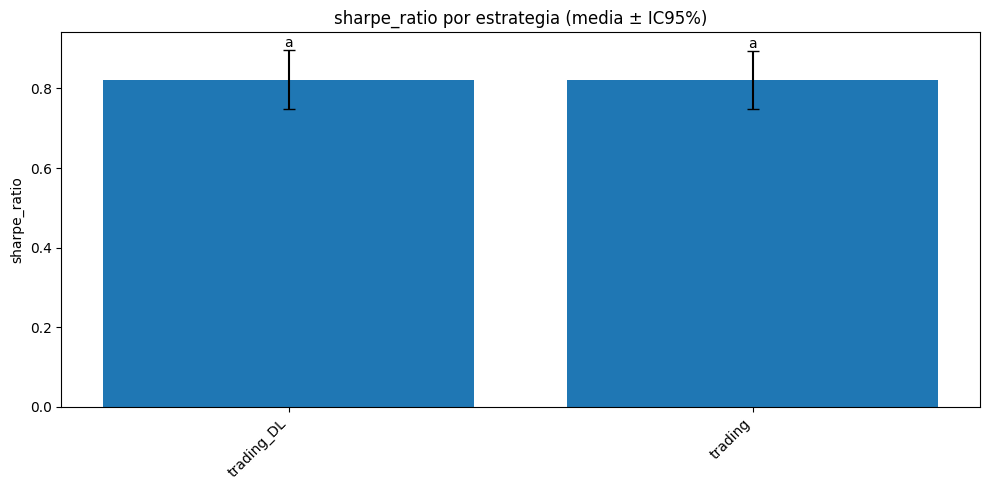

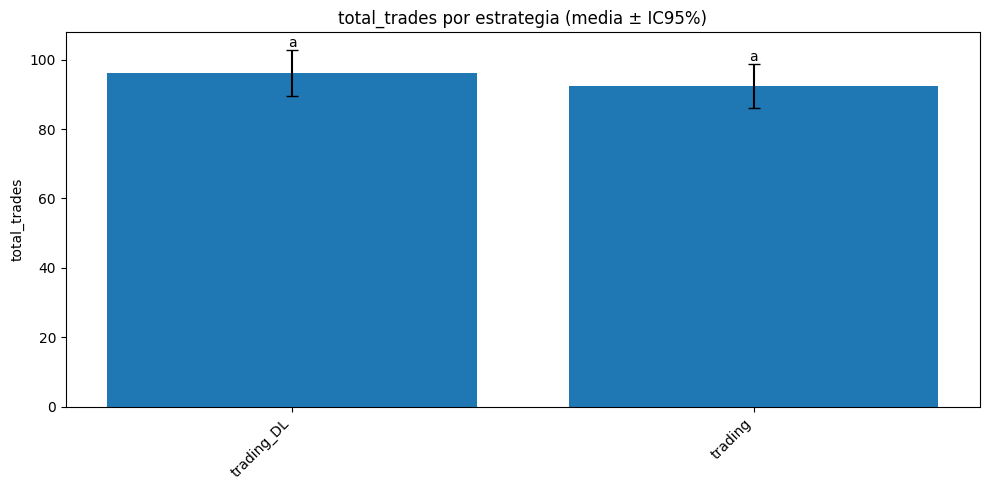

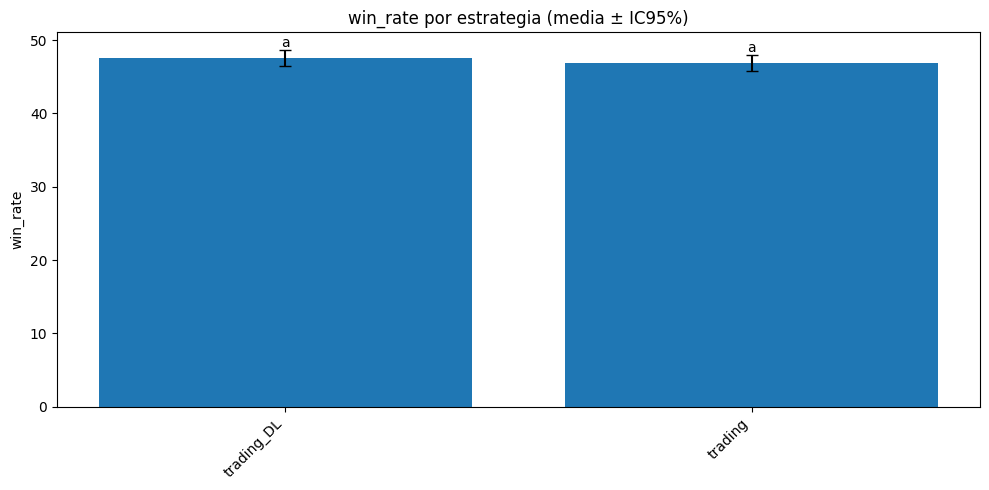


sharpe_ratio: Media e IC95% por estrategia (ordenado por desempeño)
estrategia   Mean  CI_lower  CI_upper   N Group
trading_DL 0.8222    0.7483    0.8962 101     a
   trading 0.8219    0.7486    0.8953 101     a

total_trades: Media e IC95% por estrategia (ordenado por desempeño)
estrategia    Mean  CI_lower  CI_upper   N Group
trading_DL 96.1881   89.6428  102.7334 101     a
   trading 92.3168   85.9456   98.6880 101     a

win_rate: Media e IC95% por estrategia (ordenado por desempeño)
estrategia    Mean  CI_lower  CI_upper   N Group
trading_DL 47.5413   46.4536   48.6290 101     a
   trading 46.8686   45.8049   47.9323 101     a

TABLA COMBINADA (todas las métricas)
estrategia       Metric    Mean  CI_lower  CI_upper   N Group
trading_DL sharpe_ratio  0.8222    0.7483    0.8962 101     a
   trading sharpe_ratio  0.8219    0.7486    0.8953 101     a
trading_DL total_trades 96.1881   89.6428  102.7334 101     a
   trading total_trades 92.3168   85.9456   98.6880 101     a
trading_DL 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ======================================================================================
# Requisitos: tener 're' en memoria con columnas:
# 'estrategia', 'sharpe_ratio', 'total_trades', 'win_rate'
# ======================================================================================
# Definir las métricas (ajusta según tu DataFrame)
metrics = ['sharpe_ratio', 'total_trades', 'win_rate']
# ---------------------- helpers ----------------------
def mean_ci_series(series, alpha=0.95):
    s = pd.Series(series).dropna()
    n = len(s)
    mean = s.mean()
    if n < 2:
        return mean, np.nan, np.nan, n
    sem = stats.sem(s)
    lo, hi = stats.t.interval(alpha, df=n-1, loc=mean, scale=sem)
    return mean, lo, hi, n

def pairwise_bonferroni_tests(df, metric):
    """Devuelve pares (A,B) y p-valores Bonferroni (Welch's t-test)."""
    estrategias = sorted(df['estrategia'].dropna().unique().tolist())
    pairs, pvals = [], []
    for i in range(len(estrategias)):
        for j in range(i+1, len(estrategias)):
            a, b = estrategias[i], estrategias[j]
            ga = df.loc[df['estrategia']==a, metric].dropna()
            gb = df.loc[df['estrategia']==b, metric].dropna()
            if len(ga) >= 2 and len(gb) >= 2:
                tstat, p = stats.ttest_ind(ga, gb, equal_var=False, alternative='two-sided')
            else:
                p = np.nan
            pairs.append((a, b))
            pvals.append(p)
    m = max(1, len(pvals))
    p_adj = [min(1.0, p*m) if not np.isnan(p) else np.nan for p in pvals]
    out = pd.DataFrame(pairs, columns=['A','B'])
    out['p_adj'] = p_adj
    return out, estrategias

def build_non_sig_matrix_from_pairs(pairs_df, estrategias, alpha=0.05):
    """M[i,j]=True si i y j NO difieren significativamente (p>=alpha)."""
    M = pd.DataFrame(True, index=estrategias, columns=estrategias, dtype=bool)
    if pairs_df is None or len(pairs_df)==0:
        return M
    for _, row in pairs_df.iterrows():
        a, b = row['A'], row['B']
        p = row['p_adj']
        if pd.isna(p):
            # conservador: si no hay test, marcamos como diferentes
            M.loc[a, b] = False
            M.loc[b, a] = False
        else:
            ns = p >= alpha
            M.loc[a, b] = ns
            M.loc[b, a] = ns
    return M

def assign_letters_greedy(non_sig_matrix, order_estrategias):
    """
    Asigna letras por grupos de no-significancia (heurístico).
    estrategias que no difieren entre sí comparten letra.
    """
    groups = []
    for m in order_estrategias:
        placed = False
        for g in groups:
            if all(non_sig_matrix.loc[m, other] for other in g):
                g.append(m)
                placed = True
                break
        if not placed:
            groups.append([m])

    letters = {}
    alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
    def letter_for_idx(idx):
        base = len(alphabet)
        s = ""
        idx2 = idx
        while True:
            s = alphabet[idx2 % base] + s
            if idx2 < base:
                break
            idx2 = idx2 // base - 1
            if idx2 < 0:
                break
        return s
    for gi, g in enumerate(groups):
        let = letter_for_idx(gi)
        for m in g:
            letters[m] = letters.get(m, "") + let
    return letters

def plot_metric_bars_and_get_table(metric, df, higher_is_better=True):
    # Resumen por estrategia
    estrategias = sorted(df['estrategia'].dropna().unique().tolist())
    rows = []
    for mo in estrategias:
        vals = df.loc[df['estrategia']==mo, metric].dropna()
        mean, lo, hi, n = mean_ci_series(vals)
        rows.append({'estrategia': mo, 'Mean': mean, 'CI_lower': lo, 'CI_upper': hi, 'N': n})
    summ = pd.DataFrame(rows).dropna(subset=['Mean'])

    # Ordenar (mejor primero)
    summ = summ.sort_values('Mean', ascending=not higher_is_better).reset_index(drop=True)

    # Tests por pares y letras
    pairs_df, _ = pairwise_bonferroni_tests(df, metric)
    non_sig = build_non_sig_matrix_from_pairs(pairs_df, estrategias=summ['estrategia'].tolist(), alpha=0.05)
    letters = assign_letters_greedy(non_sig, order_estrategias=summ['estrategia'].tolist())

    # --------- Plot ---------
    x = np.arange(len(summ))
    means = summ['Mean'].values
    yerr = np.vstack([means - summ['CI_lower'].values, summ['CI_upper'].values - means])
    yerr = np.nan_to_num(yerr, nan=0.0)

    plt.figure(figsize=(10, 5))
    plt.bar(x, means, yerr=yerr, capsize=4)
    plt.xticks(x, summ['estrategia'].tolist(), rotation=45, ha='right')
    plt.ylabel(metric)
    plt.title(f"{metric} por estrategia (media ± IC95%)")
    plt.tight_layout()

    # Letras encima de cada barra
    rng = (np.nanmax(means) - np.nanmin(means)) if len(means)>0 else 1.0
    offset = 0.02 * rng if rng > 0 else 0.02
    for xi, (m, mu, lo, hi) in enumerate(zip(summ['estrategia'], means, summ['CI_lower'], summ['CI_upper'])):
        label = letters.get(m, '')
        y_top = hi if not np.isnan(hi) else mu
        plt.text(xi, y_top + offset, label, ha='center', va='bottom', fontsize=10)

    plt.show()

    # Añadimos las letras a la tabla y redondeamos
    summ['Group'] = summ['estrategia'].map(letters)
    table = summ[['estrategia', 'Mean', 'CI_lower', 'CI_upper', 'N', 'Group']].copy()
    table[['Mean','CI_lower','CI_upper']] = table[['Mean','CI_lower','CI_upper']].round(4)
    return table

# ---------------------- ejecución ----------------------
required_cols = {'estrategia', 'sharpe_ratio', 'total_trades', 'win_rate'}
missing = required_cols - set(re.columns)
if missing:
    raise RuntimeError(f"re is missing required columns: {missing}")

tables_by_metric = {}
# Métricas "mayor es mejor"
for metric in metrics:
    tables_by_metric[metric] = plot_metric_bars_and_get_table(metric, re, higher_is_better=True)

# --------- Mostrar tablas por métrica ----------
for m, dfm in tables_by_metric.items():
    print("\n" + "="*80)
    print(f"{m}: Media e IC95% por estrategia (ordenado por desempeño)")
    print("="*80)
    print(dfm.to_string(index=False))

# --------- Tabla combinada (long format) ----------
summary_all = []
for m, dfm in tables_by_metric.items():
    tmp = dfm.copy()
    tmp.insert(1, 'Metric', m)
    summary_all.append(tmp)
summary_all = pd.concat(summary_all, ignore_index=True)
# columnas ordenadas
summary_all = summary_all[['estrategia', 'Metric', 'Mean', 'CI_lower', 'CI_upper', 'N', 'Group']]
print("\n" + "="*80)
print("TABLA COMBINADA (todas las métricas)")
print("="*80)
print(summary_all.to_string(index=False))

# --------- Export opcional ----------
# summary_all.to_csv('summary_means_ci_by_estrategia_metric.csv', index=False)
# with pd.ExcelWriter('summary_means_ci_by_estrategia_metric.xlsx', engine='xlsxwriter') as writer:
#     for m, dfm in tables_by_metric.items():
#         dfm.to_excel(writer, sheet_name=m, index=False)
#     summary_all.to_excel(writer, sheet_name='ALL', index=False)

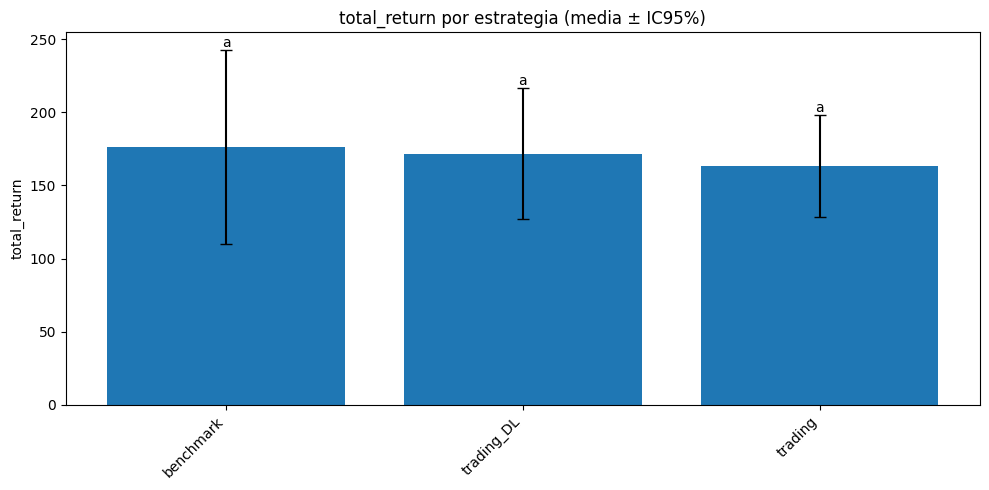


total_return: Media e IC95% por estrategia (ordenado por desempeño)
estrategia     Mean  CI_lower  CI_upper   N Group
 benchmark 176.2039  109.8342  242.5737 101     a
trading_DL 171.7391  126.9051  216.5731 101     a
   trading 163.3827  128.6318  198.1336 101     a

TABLA COMBINADA (todas las métricas)
estrategia       Metric     Mean  CI_lower  CI_upper   N Group
 benchmark total_return 176.2039  109.8342  242.5737 101     a
trading_DL total_return 171.7391  126.9051  216.5731 101     a
   trading total_return 163.3827  128.6318  198.1336 101     a


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ======================================================================================
# Requisitos: tener 'returns' en memoria con columnas:
# 'estrategia', 'total_return'
# ======================================================================================
# Definir las métricas (ajusta según tu DataFrame)
metrics = ['total_return']

# ---------------------- ejecución ----------------------
required_cols = {'estrategia', 'total_return'}
missing = required_cols - set(returns.columns)
if missing:
    raise RuntimeError(f"returns is missing required columns: {missing}")

tables_by_metric = {}
# Métricas "mayor es mejor"
for metric in metrics:
    tables_by_metric[metric] = plot_metric_bars_and_get_table(metric, returns, higher_is_better=True)

# --------- Mostrar tablas por métrica ----------
for m, dfm in tables_by_metric.items():
    print("\n" + "="*80)
    print(f"{m}: Media e IC95% por estrategia (ordenado por desempeño)")
    print("="*80)
    print(dfm.to_string(index=False))

# --------- Tabla combinada (long format) ----------
summary_all = []
for m, dfm in tables_by_metric.items():
    tmp = dfm.copy()
    tmp.insert(1, 'Metric', m)
    summary_all.append(tmp)
summary_all = pd.concat(summary_all, ignore_index=True)
# columnas ordenadas
summary_all = summary_all[['estrategia', 'Metric', 'Mean', 'CI_lower', 'CI_upper', 'N', 'Group']]
print("\n" + "="*80)
print("TABLA COMBINADA (todas las métricas)")
print("="*80)
print(summary_all.to_string(index=False))

# --------- Export opcional ----------
# summary_all.to_csv('summary_means_ci_by_estrategia_metric.csv', index=False)
# with pd.ExcelWriter('summary_means_ci_by_estrategia_metric.xlsx', engine='xlsxwriter') as writer:
#     for m, dfm in tables_by_metric.items():
#         dfm.to_excel(writer, sheet_name=m, index=False)
#     summary_all.to_excel(writer, sheet_name='ALL', index=False)